# Motivation
In this notebook, I want to *really* refine the methods that I was messing around with in **`02. Better Board Detection`**. 

Once I have the process streamlined a lot, I can run through some automated testing (since I've labeled a bunch of the pictures). 

# Setup
The cells below will set up the rest of this notebook. 

First, I'll configure the kernel: 

In [1]:
# Change directories to the root of the project
%cd ..

# Enable autoreload of modules
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision


Next, I'll import some relevant libraries:

In [2]:
# Import statements
import cv2
import pandas as pd
from pathlib import Path
import math
from matplotlib import pyplot as plt
import numpy as np
from statistics import mode
import utils
import cv2
import pytesseract
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Importing custom modules
import utils.board_detection as board_detect

# Loading Data
Here, I'm going to load in all of the pictures, as well as some information about each of them. 

In [3]:
# Open the .csv file containing the labeled boards
board_data_df = pd.read_csv("data/labeled-boards.csv")

# Add a column which is the parsed letter sequence
board_data_df["parsed_letter_sequence"] = board_data_df["letter_sequence"].apply(
    lambda letter_list: letter_list.split(";")
)

# Load all of the images using cv2
file_path_to_image = {}
for row in board_data_df.itertuples():
    file_path_to_image[row.file_path] = cv2.imread(row.file_path)

# Board Detection Process
Below, I'm going to run through the board detection process. 

Each step should generally try and follow these rules: 

- Be relatively discrete; some data structure will be passed into some methods, and some additional data structures will be passed out. 
- Mostly everything ought to be methodized and placed into `utils/board_detection.py`. 

### **Step 0:** Setting the Detection Process
Below, I'll declare a couple of settings for the board detection process. 

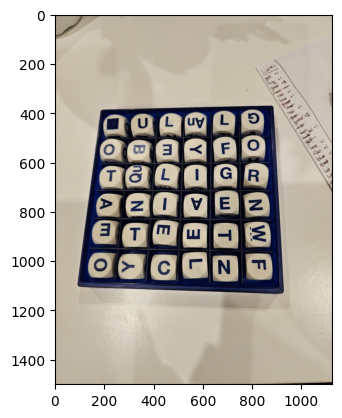

In [111]:
# Parameterizing the board detection algorithm
max_image_height = 1500

# Indicating a test image to use
input_image_path = "data/test-pictures/easy-02.png"

# Load the image into memory
input_image = cv2.imread(input_image_path)

# Resize the image to a smaller size
input_image = board_detect.resize_image(input_image, max_image_height)

# Show the image
board_detect.show_cv2_image(input_image)

### **Step 1:** Locating the Board 

In this step, we'll run through some contour detection for locating the board. 

In [112]:
# Parameterizing the method
n_top_contours_to_consider = 200
min_board_area_threshold = 0.15
max_board_area_threshold = 0.8
board_contour_expansion_size = 25
polygon_approximation_epsilon = 0.05
binary_threshold_value = 100

# Detect the board contour
boggle_board_contour = board_detect.detect_boggle_board_contour(
    input_image,
    n_top_contours_to_consider,
    min_board_area_threshold,
    max_board_area_threshold,
    board_contour_expansion_size,
    polygon_approximation_epsilon,
    binary_threshold_value,
)

Now that the board's been detected, we'll show the contour. 

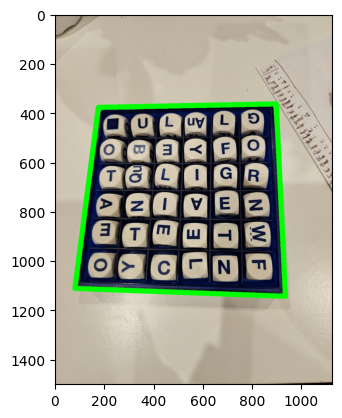

In [113]:
board_detect.draw_contours(
    cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB),
    [boggle_board_contour],
    color=(0, 255, 0),
    thickness=20,
)

### **Step 2:** Warping Image Perspective
Next, we're going to use a method to warp the perspective of the image to a top-down view. This way, we'll get a clearer view of the board. 

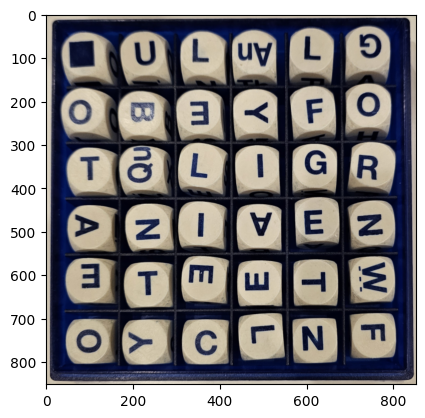

In [114]:
# Warp the input image to get a top-down view of the board
top_down_board_image = board_detect.warp_perspective_to_top_down(
    input_image, boggle_board_contour
)

# Next, we'll show off what this looks like
board_detect.show_cv2_image(top_down_board_image)

### **Step 3:** Tile Contour Detection
Next up: I'm going to detect the contours of each of the letter tiles within the board.

In [115]:
# Parameterizing the tile detection process
binary_threshold_value = 100
min_tile_area_percentage = 0.0003
max_tile_area_percentage = 0.02
tile_size_difference_threshold = 0.3
polygon_approximation_epsilon = 0.02

# Run the tile detection process
tile_contours_df = board_detect.detect_tile_contours(
    top_down_board_image=top_down_board_image,
    binary_threshold_value=binary_threshold_value,
    min_tile_area_percentage=min_tile_area_percentage,
    max_tile_area_percentage=max_tile_area_percentage,
    tile_size_difference_threshold=tile_size_difference_threshold,
)

Now that I've detected all of the contours in the image, I'm going to show them. 

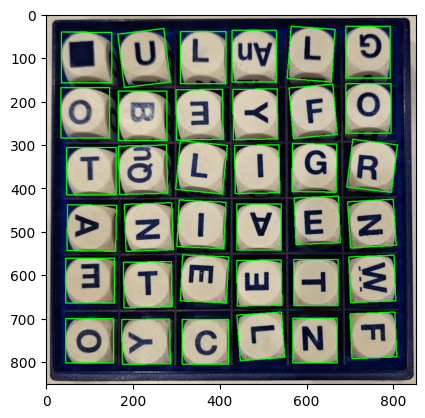

In [116]:
board_detect.draw_contours(
    cv2.cvtColor(top_down_board_image, cv2.COLOR_BGR2RGB),
    list(tile_contours_df["contour"]),
    color=(0, 255, 0),
    thickness=2,
)

### **Step 4:** Tile Image Extraction
The next step is tile image extraction. Here, we're going to to try and extract an image corresponding with each tile, and then clean up the image! 

In [117]:
# Parameterize this method
min_contour_pct_of_total_area = 0.003
polygon_approximation_epsilon = 0.025
min_contour_in_underline = 2
binary_threshold_value=200
adaptive_threshold_kernel_size_relative=0.015
adaptive_threshold_C=5
resize_size = 50

# Run the tile extraction method
extracted_tile_img_dict = board_detect.extract_tile_images(
    top_down_board_image=top_down_board_image,
    tile_contours_df=tile_contours_df,
    min_contour_pct_of_total_area=min_contour_pct_of_total_area,
    polygon_approximation_epsilon=polygon_approximation_epsilon,
    min_contour_in_underline=min_contour_in_underline,
    adaptive_threshold_kernel_size_relative=adaptive_threshold_kernel_size_relative,
    adaptive_threshold_C=adaptive_threshold_C,
    resize_size=resize_size
)


Detected underline contours in tile 29.
proper rotation: 270


Now that we've extracted each of the tile images, we'll show them. 

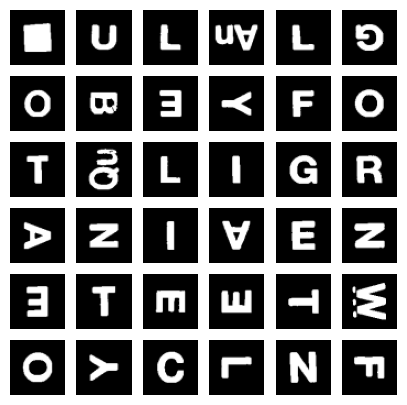

In [118]:
# Extract a list of the images from the dictionary
tile_images_list = [image for tile_idx, image in extracted_tile_img_dict.items()]

# Display the images in a grid
board_detect.display_images_in_grid(
    tile_images_list, grid_size=int(math.sqrt(len(tile_images_list)))
)

# **TODO:**

### Step 4: 
- Center the whitespace of the tile
- Uniform size for all images 
- Create some sort of "helper metadata" which contains information about whether or not I's, W's, Z's, M's, etc. were detected 

### Step 5: 
- EVERYTHING